In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
train = pd.read_csv("playground-series-s5e5/train.csv")
test = pd.read_csv("playground-series-s5e5/test.csv")

Adding original dataset for training. 

In [3]:
train_extra = pd.read_csv("calories-burning-dataset/exercise.csv")
train_cal = pd.read_csv("calories-burning-dataset/calories.csv")

In [4]:
train.drop(columns=['id'], inplace=True)

In [5]:
train.shape, train_extra.shape

((750000, 8), (15000, 8))

In [6]:
train_extra.drop(columns=['User_ID'], inplace=True)

In [7]:
train_extra.columns, train.columns

(Index(['Gender', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
        'Body_Temp'],
       dtype='object'),
 Index(['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
        'Calories'],
       dtype='object'))

In [8]:
train_extra.head()

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,male,68,190.0,94.0,29.0,105.0,40.8
1,female,20,166.0,60.0,14.0,94.0,40.3
2,male,69,179.0,79.0,5.0,88.0,38.7
3,female,34,179.0,71.0,13.0,100.0,40.5
4,female,27,154.0,58.0,10.0,81.0,39.8


In [9]:
train_extra.rename(columns={'Gender': 'Sex'}, inplace=True)
train_extra['Calories'] = train_cal['Calories'].values

In [10]:
train_extra.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [11]:
train_extra = train_extra[train.columns]  

In [12]:
df = pd.concat([train, train_extra], ignore_index=True)

In [13]:
df.shape

(765000, 8)

In [14]:
df.isna().sum()

Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [15]:
df.duplicated().value_counts()

False    762107
True       2893
Name: count, dtype: int64

In [16]:
df = df[~df.duplicated()].reset_index(drop=True)

In [17]:
df.describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,762107.000000,762107.000000,762107.000000,762107.000000,762107.000000,762107.000000,762107.000000
mean,41.446593,174.690104,75.136995,15.435313,95.495988,40.037079,88.387137
std,15.221503,12.849988,13.998134,8.351997,9.453520,0.779234,62.397255
min,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [18]:
df.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [19]:
df.shape

(762107, 8)

* Duration and Heart Rate has high positive correlation with calories. These are important features for model.
* Height and Weight have high correlation with each other and might cause multicollinearity, which can make training unstable, cause redundancy and impact model interpretability.
* Low correlation with calories (e.g. Height) suggests this is irrelavant, or might interact with others in non-obvious ways (e.g. weight). We can consider cross terms or nonlinear transformations.

# Data preprocessing

For random forests, we do not need to create dummy variables. Instead, we can convert the fields to categorical variables. Internally in pandas, this creates a list of all unique values in the column and replaces each value with a number. The number is just an index for looking up the value in the list of all unique values.

In [20]:
def impute_outliers(series):
    q1 = np.percentile(series, 25)
    q3 = np.percentile(series, 75)
    IQR = q3 - q1
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR
    return np.clip(series, lower_bound, upper_bound)

In [21]:
have_outliers = ['Height', 'Weight', 'Heart_Rate', 'Body_Temp']
for feat in have_outliers:
    df[feat] = impute_outliers(df[feat])

In [22]:
def proc_data(df):
    df['Sex'] = pd.Categorical(df.Sex)
    df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)
    return df

train_df = proc_data(df)
test_df = proc_data(test)

In [23]:
numerical_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

def add_feature_cross_terms(df, numerical_features):
    df_new = df.copy()
    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
    # df_new = df_new.drop(columns = ['Weight', 'Height',])
    return df_new

train_df = add_feature_cross_terms(train_df, numerical_features)
test_df = add_feature_cross_terms(test_df, numerical_features)

In [24]:
train_df["y_train"] = np.log1p( train_df["Calories"])

In [25]:
train_df.columns, test_df.columns

(Index(['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
        'Calories', 'BMI', 'Age_x_Height', 'Age_x_Weight', 'Age_x_Duration',
        'Age_x_Heart_Rate', 'Age_x_Body_Temp', 'Height_x_Weight',
        'Height_x_Duration', 'Height_x_Heart_Rate', 'Height_x_Body_Temp',
        'Weight_x_Duration', 'Weight_x_Heart_Rate', 'Weight_x_Body_Temp',
        'Duration_x_Heart_Rate', 'Duration_x_Body_Temp',
        'Heart_Rate_x_Body_Temp', 'y_train'],
       dtype='object'),
 Index(['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
        'Body_Temp', 'BMI', 'Age_x_Height', 'Age_x_Weight', 'Age_x_Duration',
        'Age_x_Heart_Rate', 'Age_x_Body_Temp', 'Height_x_Weight',
        'Height_x_Duration', 'Height_x_Heart_Rate', 'Height_x_Body_Temp',
        'Weight_x_Duration', 'Weight_x_Heart_Rate', 'Weight_x_Body_Temp',
        'Duration_x_Heart_Rate', 'Duration_x_Body_Temp',
        'Heart_Rate_x_Body_Temp'],
       dtype='object'))

In [26]:
cats=["Sex"]
conts=[ 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
        'Body_Temp', 'BMI', 'Age_x_Height', 'Age_x_Weight', 'Age_x_Duration',
        'Age_x_Heart_Rate', 'Age_x_Body_Temp', 'Height_x_Weight',
        'Height_x_Duration', 'Height_x_Heart_Rate', 'Height_x_Body_Temp',
        'Weight_x_Duration', 'Weight_x_Heart_Rate', 'Weight_x_Body_Temp',
        'Duration_x_Heart_Rate', 'Duration_x_Body_Temp',
        'Heart_Rate_x_Body_Temp']
dep="y_train"

In [27]:
train_df.Sex.head()

0      male
1    female
2    female
3      male
4    female
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [28]:
train_df.Sex.cat.codes.head()

0    1
1    0
2    0
3    1
4    0
dtype: int8

In [29]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(train_df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [30]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [31]:
trn_df.corr(numeric_only=True)["Calories"].sort_values(ascending=False)

Calories                  1.000000
Duration_x_Heart_Rate     0.977235
Duration_x_Body_Temp      0.960746
Duration                  0.959744
Height_x_Duration         0.954195
Heart_Rate_x_Body_Temp    0.924607
Weight_x_Duration         0.912365
Heart_Rate                0.908437
y_train                   0.902394
Age_x_Duration            0.854198
Body_Temp                 0.834922
Height_x_Heart_Rate       0.733164
Weight_x_Heart_Rate       0.445312
Age_x_Heart_Rate          0.381844
Height_x_Body_Temp        0.210514
Age_x_Body_Temp           0.190139
Age                       0.145858
Age_x_Height              0.144979
Age_x_Weight              0.140089
Weight_x_Body_Temp        0.104023
BMI                       0.049911
Weight                    0.017280
Height_x_Weight           0.013863
Sex                       0.013039
Height                   -0.002626
Name: Calories, dtype: float64

# Random Forests

In [32]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    min_samples_leaf=5,
    n_jobs=-1,          # Use all cores
    verbose=1           # Show progress
)

rf.fit(trn_xs, trn_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.7s finished


RandomForestRegressor(min_samples_leaf=5, n_jobs=-1, verbose=1)

In [33]:
from sklearn.metrics import root_mean_squared_error
root_mean_squared_error(val_y, rf.predict(val_xs))

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.4s finished


0.061575117976574174

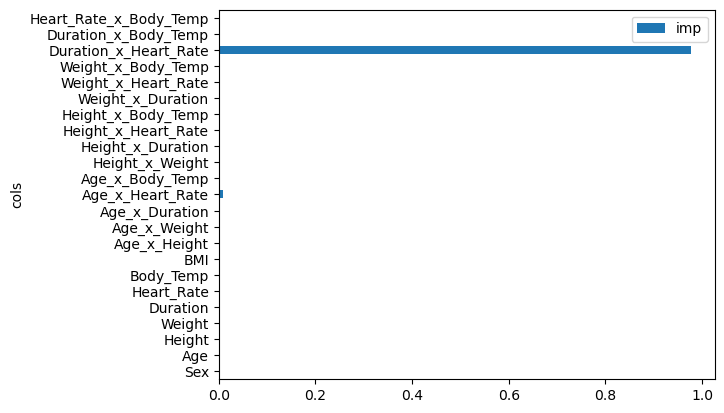

In [34]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');

In [35]:
test_copy = test_df.copy()
test_copy.shape, test_df.shape

((250000, 24), (250000, 24))

In [36]:
test_copy = test_copy.drop(columns = ['id'])

In [37]:
test_copy[cats] = test_copy[cats].apply(lambda x: x.cat.codes)

In [38]:
avg_probs = rf.predict(test_copy)

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.6s finished


In [39]:
final_preds = np.expm1(avg_probs)
final_preds.min(), final_preds.max()

(1.023492533312409, 309.13753570380646)

In [40]:
final_preds = np.clip(final_preds, train_df["Calories"].min(), train_df["Calories"].max())  

final_preds.min(), final_preds.max()

(1.023492533312409, 309.13753570380646)

In [41]:
test_df['Calories'] = final_preds
sub_df = test_df[['id','Calories']]

In [42]:
test_df['Calories'] 

0          27.378028
1         107.076584
2          87.249144
3         126.596486
4          75.491674
             ...    
249995     26.128451
249996      9.192203
249997     73.930298
249998    170.134178
249999     77.414899
Name: Calories, Length: 250000, dtype: float64

In [43]:
test_df['Calories'] 

0          27.378028
1         107.076584
2          87.249144
3         126.596486
4          75.491674
             ...    
249995     26.128451
249996      9.192203
249997     73.930298
249998    170.134178
249999     77.414899
Name: Calories, Length: 250000, dtype: float64

In [44]:
sub_df.to_csv('rp_corr_with log.csv', index=False)

With new feature as intensity = heart rate * duration: score 0.07372
without it : 0.06463

# XGB Regressor

In [45]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6)
model.fit(trn_xs, trn_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [46]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, trn_xs, trn_y, cv=5, scoring='neg_root_mean_squared_error')
print("RMSE:", -scores.mean())

RMSE: 0.06046191619197831


In [47]:
root_mean_squared_error(val_y, model.predict(val_xs))

0.059824657871338095

In [48]:
xgb_probs = model.predict(test_copy)

In [49]:
xgb_final_preds = np.expm1(xgb_probs)
xgb_final_preds.min(), xgb_final_preds.max()

(0.88734484, 299.52878)

In [50]:
xgb_final_preds = np.clip(xgb_final_preds, train_df["Calories"].min(), train_df["Calories"].max())  

xgb_final_preds.min(), final_preds.max()

(1.0, 309.13753570380646)

In [51]:
test_df['Calories'] = xgb_final_preds
sub_df = test_df[['id','Calories']]

In [52]:
test_df['Calories'] 

0          27.524323
1         108.111511
2          85.407051
3         125.359184
4          75.210258
             ...    
249995     25.705809
249996      9.157160
249997     72.286148
249998    169.212036
249999     76.075813
Name: Calories, Length: 250000, dtype: float32

In [53]:
sub_df.to_csv('xgb.csv', index=False)

Score using xgb: 0.05818

# LGBM Regressor

In [54]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

# Define the model
model = LGBMRegressor(random_state=42, n_estimators=100, learning_rate=0.01)

# Evaluate using cross-validation
scores = cross_val_score(model, trn_xs, trn_y, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-validated RMSE:", -scores.mean())

# Fit on full training data
model.fit(trn_xs, trn_y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4417
[LightGBM] [Info] Number of data points in the train set: 457264, number of used features: 23
[LightGBM] [Info] Start training from score 4.142278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4415
[LightGBM] [Info] Number of data points in the train set: 457264, number of used features: 23
[LightGBM] [Info] Start training from score 4.142508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4415
[LightGBM] [Info] Number of data points in the train set: 457264, number of used features: 23
[LightGBM] [Info] Start 

LGBMRegressor(learning_rate=0.01, random_state=42)

In [55]:
root_mean_squared_error(val_y, model.predict(val_xs))

0.36689905308159587

In [56]:
# Predict on test set
test_predictions = model.predict(test_copy)

In [57]:
gb_final_preds = np.expm1(test_predictions)
gb_final_preds.min(), gb_final_preds.max()

(8.97259606375092, 140.8391666221777)

In [58]:
test_df['Calories'] = xgb_final_preds
sub_df = test_df[['id','Calories']]
sub_df.to_csv('lgb_gscv.csv', index=False)

In [59]:
test_df['Calories'] 

0          27.524323
1         108.111511
2          85.407051
3         125.359184
4          75.210258
             ...    
249995     25.705809
249996      9.157160
249997     72.286148
249998    169.212036
249999     76.075813
Name: Calories, Length: 250000, dtype: float32

Score using LGBM: 0.05816

# XGB regressor using parameter tuning

In [60]:
from xgboost import XGBRegressor
model2 = XGBRegressor(n_estimators=1000, learning_rate=0.02, max_depth=7, subsample = 0.8)
model2.fit(trn_xs, trn_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [61]:
scores = cross_val_score(model2, trn_xs, trn_y, cv=5, scoring='neg_root_mean_squared_error')
print("RMSE:", -scores.mean())

RMSE: 0.06016854742487646


In [62]:
root_mean_squared_error(val_y, model2.predict(val_xs))

0.059509745553391585

In [63]:
test_predictions = model2.predict(test_copy)

gb_final_preds = np.expm1(test_predictions)
gb_final_preds.min(), gb_final_preds.max()

(0.9706747, 297.83115)

In [64]:
gb_final_preds

array([ 27.739214, 108.721375,  86.76182 , ...,  73.56586 , 168.74129 ,  75.846924], dtype=float32)

In [65]:
test_df['Calories'] = gb_final_preds
sub_df = test_df[['id','Calories']]
sub_df.to_csv('xgb_gscv_optimized.csv', index=False)

Score: 0.05795

# CatBoost

In [66]:
from catboost import CatBoostRegressor

model3 = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg = 1,
    cat_features=cats,  
    thread_count=-1,                 # Use all available CPU cores
    verbose=100
)

model3.fit(trn_xs, trn_y)

0:	learn: 0.8732995	total: 74.5ms	remaining: 3m 43s
100:	learn: 0.0633380	total: 1.28s	remaining: 36.6s
200:	learn: 0.0606845	total: 2.49s	remaining: 34.7s
300:	learn: 0.0594313	total: 3.7s	remaining: 33.2s
400:	learn: 0.0586176	total: 4.9s	remaining: 31.8s
500:	learn: 0.0580224	total: 6.18s	remaining: 30.9s
600:	learn: 0.0575185	total: 7.38s	remaining: 29.5s
700:	learn: 0.0570704	total: 8.6s	remaining: 28.2s
800:	learn: 0.0566844	total: 9.82s	remaining: 27s
900:	learn: 0.0563248	total: 11.2s	remaining: 26.1s
1000:	learn: 0.0559916	total: 12.4s	remaining: 24.8s
1100:	learn: 0.0556982	total: 13.6s	remaining: 23.5s
1200:	learn: 0.0554365	total: 14.8s	remaining: 22.2s
1300:	learn: 0.0551811	total: 16.1s	remaining: 21s
1400:	learn: 0.0549449	total: 17.2s	remaining: 19.7s
1500:	learn: 0.0547176	total: 18.5s	remaining: 18.4s
1600:	learn: 0.0544893	total: 19.7s	remaining: 17.2s
1700:	learn: 0.0542874	total: 20.9s	remaining: 16s
1800:	learn: 0.0541009	total: 22.2s	remaining: 14.8s
1900:	learn:

In [67]:
root_mean_squared_error(val_y, model3.predict(val_xs))

0.05919846788326923

In [68]:
test_predictions = model3.predict(test_copy)

gb_final_preds = np.expm1(test_predictions)
gb_final_preds.min(), gb_final_preds.max()

(0.7215929222834908, 306.49961320522)

In [69]:
test_df['Calories'] = gb_final_preds
sub_df = test_df[['id','Calories']]
sub_df.to_csv('catboost.csv', index=False)

In [70]:
test_df['Calories']

0          27.457446
1         107.301579
2          86.990886
3         125.137648
4          76.101506
             ...    
249995     26.142865
249996      9.468223
249997     72.993615
249998    168.761317
249999     76.846583
Name: Calories, Length: 250000, dtype: float64

Score: 0.05795

<div align="center">

### 📊 Model Performance Summary

| Model                                 | Feature Engineering Details                      | RMSE Score |
|--------------------------------------|--------------------------------------------------|------------|
| Random Forest                        | With `intensity = Heart Rate × Duration`        | 0.07372    |
| Random Forest                        | Without `intensity` feature                      | 0.06463    |
| XGBoost                              | Basic                                            | 0.05818    |
| LightGBM                             | Basic                                            | 0.05816    |
| XGBoost (Tuned Parameters)           | After Hyperparameter Optimization                | 0.05795    |
| CatBoost                             | After Hyperparameter Optimization                | 0.05795    |

</div>
